In [18]:
# Imports
import pandas as pd
import json
import os
from IPython.display import display
import pywikibot
import requests
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [19]:
# Data source: http://www.cs.cmu.edu/~ark/personas/

# Define the paths
DATA_PATH = 'data/'
CLEAN_DATA_PATH = 'clean_data/'

# 1. Part 1: Data exploration

In [20]:
# Load all the data and add the column names
movies_df = pd.read_csv(DATA_PATH + 'movie.metadata.tsv', delimiter='\t', header=None, names=['wiki_id', 'id', 'name', 'release_date', 'revenue', 'runtime', 'languages', 'countries', 'genres'])

## 1. Step 1: Data cleaning 

The goal of this part is to reformat the data, remove the json strings, and uniformize the data. While doing so, we will also group the countries into world regions that will be used later on for the analysis.

In [21]:
# As we already cleaned the data before submission, we can skip those steps
PERFORM_CLEANING = False

### 1.1 Grouping the countries into world regions

We firstly wanted to categorize the movies into three categories: Hollywood, Bollywood and Nollywood. However, we first did not have this information into the dataset, and second there was not enough data in the Nollywood category to do so.

In [22]:
# Convert the json string to a list of countries
movies_df["countries"] = movies_df["countries"].apply(lambda x: list(json.loads(x).values()))

In [23]:
# Count the number of movies that are assigned to each countries. 
# Duplicate the movies if they have multiple countries.

nb_movies_per_country = movies_df["countries"].explode().value_counts()
display(nb_movies_per_country.head(20))

countries
United States of America    34408
India                        8411
United Kingdom               7868
France                       4395
Italy                        3163
Japan                        2647
Canada                       2534
Germany                      2393
Argentina                    1468
Hong Kong                    1240
Spain                        1136
Australia                    1114
South Korea                   887
Mexico                        870
Netherlands                   840
Sweden                        657
West Germany                  647
China                         645
Denmark                       610
Soviet Union                  564
Name: count, dtype: int64

None of the 20 first most represented country can be used for Nollywood. Since there also will be data cleaning in the next steps due to NaN information. We decided to not use this categorization.

We will instead use the world regions to categorize the movies. We will use the following world regions and group the countries into them:
- Northen America: United States of America, Canada
- Europe: United Kingdom, France, Italy, Germany, Spain, West Germany, Belgium, German Democratic Republic, Ireland, Switzerland, Austria, England, Luxembourg, Portugal
- Asia: Japan, Hong Kong, China, South Korea, Taiwan
- India: India, Pakistan

In [24]:
areas = {
	"Northen America": set(["United States of America", "Canada"]),
	"Europe": set(["United Kingdom", "France", "Italy", "Germany", "Spain", "West Germany", "Belgium", "German Democratic Republic", "Ireland", "Switzerland", "Austria", "England", "Luxembourg", "Portugal"]),
	"Asia": set(["Japan", "Hong Kong", "China", "South Korea", "Taiwan"]),
	"India": set(["India", "Pakistan"])
}
country_to_area = {country: area for area, countries in areas.items() for country in countries}

def get_area(country):
	if country in country_to_area:
		return country_to_area[country]
	else:
		return "Other"

# Count the number of movies that are assigned to each area.
# Duplicate the movies if they have multiple countries.
movies_areas_df = movies_df.copy()
movies_areas_df = movies_areas_df['countries'].apply(lambda x: [get_area(country) for country in x])
nb_movies_per_area = movies_areas_df.explode().value_counts()
display(nb_movies_per_area)

countries
Northen America    36942
Europe             21571
Other              13731
India               8600
Asia                5595
Name: count, dtype: int64

As we can see, those four categories will have enough data for us to still be able to clean them and do the analysis.

Keep in mind that those categories are not perfect, and that some countries are missing, or overlap. That's why we now will group the countries into those categories.

First, one thing that stroke us is that each movie can have multiple countries. 

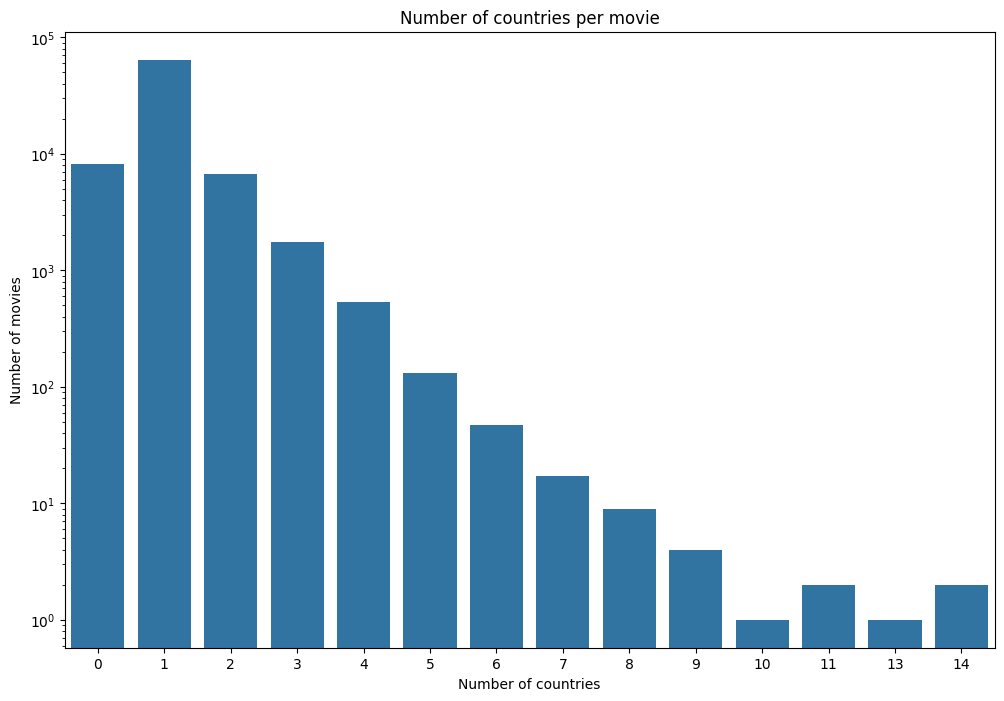

In [25]:
# Plot the bar plot of the number of countries per movie (log scale)
plt.figure(figsize=(12, 8))
plt.title("Number of countries per movie")
plt.xlabel("Number of countries")
plt.ylabel("Number of movies")
sns.countplot(x=movies_df["countries"].apply(len))
plt.yscale('log')
plt.show()

Since nothing is specified in the dataset about what represent those countries, we will assume that we cannot choose when there are multiple countries.

One way to handle this problem is to say that if there is only one country in the list, we will use it. If there are multiple countries and every of those countries are in the same world region, we will group them in the region directly. If there are multiple countries and they are not all in the same region, we will use the Wikipedia API to get the real country of the movie.

In fact, this third option involving GET requests takes a lot of time (less than 2 movies per second), so we wanted to avoid using it as much as possible.

In [26]:
# Set default area to None
movies_df["area"] = None

print(f"There are {len(movies_df)} movies in total")

There are 81741 movies in total


In [27]:
# Set the areas if the number of countries played in is 1
movies_without_area_df = movies_df[movies_df["countries"].apply(lambda x: len(x) == 1)]
movies_df.loc[movies_without_area_df.index, "area"] = movies_without_area_df["countries"].apply(lambda x: get_area(x[0]))

print(f"Fetching areas for {len(movies_without_area_df)} movies (remaining {len(movies_df[movies_df['area'].isnull()])})")
display(movies_df.loc[movies_without_area_df.index, ["id", "countries", "area"]].head(10))

Fetching areas for 64369 movies (remaining 17372)


,id,countries,area
0,/m/03vyhn,[United States of America],Northen America
1,/m/08yl5d,[United States of America],Northen America
2,/m/0crgdbh,[Norway],Other
3,/m/0285_cd,[United Kingdom],Europe
4,/m/01mrr1,[Germany],Europe
5,/m/03cfc81,[United States of America],Northen America
6,/m/04jcqvw,[South Africa],Other
7,/m/02qc0j7,[United States of America],Northen America
8,/m/06_y2j7,[Argentina],Other
9,/m/075f66,[United Kingdom],Europe


In [28]:
def get_area_from_unanimity(countries):
	area = None
	for country in countries:
		if country in country_to_area:
			if area is None:
				area = country_to_area[country]
			elif area != country_to_area[country]:
				return None
		else:
			return None
	return area

# For each remaining movie (only the ones with None as area), if the countries played in are in the same area, set the area to that area
movies_without_area_df = movies_df[movies_df["area"].isnull()]
movies_df.loc[movies_without_area_df.index, "area"] = movies_without_area_df["countries"].apply(lambda x: get_area_from_unanimity(x))

print(f"Combining areas for {len(movies_without_area_df)} movies (remaining {len(movies_df[movies_df['area'].isnull()])})")
display(movies_df.loc[movies_without_area_df.index, ["id", "countries", "area"]].head(10))

Combining areas for 17372 movies (remaining 14423)


,id,countries,area
16,/m/0g5qvzg,[],None
26,/m/05pckh0,"[France, Italy]",Europe
33,/m/04j284s,"[United States of America, United Kingdom]",None
38,/m/0b6c_nw,"[Australia, New Zealand]",None
42,/m/0gyv1h1,[],None
47,/m/0b6kc_5,"[United States of America, Netherlands]",None
50,/m/05c4bry,[],None
53,/m/02vlsqt,"[Mexico, United States of America]",None
58,/m/05f6kpj,"[Germany, Denmark, Sweden, Norway]",None
64,/m/0dll97s,[],None


As the last step took us more than 8 hours to run, we decided to save the data in a csv file, and to load it directly in the next steps.

In [29]:
wikipedia = pywikibot.Site('en', 'wikipedia')
country_property = 'P495'

def get_area_from_wikipedia(movie_wiki_id):
	try:
		wiki_api_url = f'https://en.wikipedia.org/w/api.php?action=query&pageids={movie_wiki_id}&format=json'
		json_data = requests.get(wiki_api_url).json()
		movie_title = json_data["query"]["pages"][str(movie_wiki_id)]["title"]
		movie_page = pywikibot.Page(wikipedia, movie_title)
		movie_item = pywikibot.ItemPage.fromPage(movie_page)
		movie_item_dict = movie_item.get()
		movie_country = movie_item_dict["claims"][country_property][0].getTarget().labels["en"]
		return country_to_area[movie_country] if movie_country in country_to_area else "Other"
	except:
		return "Not found"
	
# For each remaining movie (that had the number of countries played in != 1), we set the area retrieved from wikipedia by scraping
movies_without_area_df = movies_df[movies_df["area"].isnull()]
if PERFORM_CLEANING:
	movies_df.loc[movies_without_area_df.index, "area"] = movies_without_area_df["wiki_id"].apply(lambda x: get_area_from_wikipedia(x))

print(f"Retriving areas for {len(movies_without_area_df)} movies (remaining {len(movies_df[movies_df['area'].isnull()])})")
display(movies_df.loc[movies_without_area_df.index, ["id", "countries", "area"]].head(10))

Retriving areas for 14423 movies (remaining 14423)


,id,countries,area
16,/m/0g5qvzg,[],None
33,/m/04j284s,"[United States of America, United Kingdom]",None
38,/m/0b6c_nw,"[Australia, New Zealand]",None
42,/m/0gyv1h1,[],None
47,/m/0b6kc_5,"[United States of America, Netherlands]",None
50,/m/05c4bry,[],None
53,/m/02vlsqt,"[Mexico, United States of America]",None
58,/m/05f6kpj,"[Germany, Denmark, Sweden, Norway]",None
64,/m/0dll97s,[],None
66,/m/05bzp6g,"[Australia, United Kingdom, New Zealand]",None


Now, the most part of the movies has a country and therefore a world region attached to it. It will then be used during the rest of the analysis.

### 1.2 Cleaning and reformat the data

We will now clean the data and reformat it. We will do the following steps:
- Remove the json strings
- Separate the multiple values into other dataframes (to have a database like structure)
- Save them in a csv file

In [30]:
# Separate the json columns for the movies table

# Separate the languages to another table
movies_df["languages"] = movies_df["languages"].apply(lambda x: list(json.loads(x).values())) # Convert the json string to a list of languages
movies_languages_df = movies_df[["id", "languages"]].explode("languages").reset_index(drop=True)
movies_languages_df = movies_languages_df.rename(columns={"languages": "language", "id": "movie_id"})
display(movies_languages_df.head())

# Separate the genres to another table
movies_df["genres"] = movies_df["genres"].apply(lambda x: list(json.loads(x).values())) # Convert the json string to a list of genres
movies_genres_df = movies_df[["id", "genres"]].explode("genres").reset_index(drop=True)
movies_genres_df = movies_genres_df.rename(columns={"genres": "genre", "id": "movie_id"})
display(movies_genres_df.head())

# Separate the countries to another table
# The countries are already a list of countries
movies_countries_playedin_df = movies_df[["id", "countries"]].explode("countries").reset_index(drop=True)
movies_countries_playedin_df = movies_countries_playedin_df.rename(columns={"countries": "country", "id": "movie_id"})
display(movies_countries_playedin_df.head())

# Drop the useless columns (that have been separated)
movies_df = movies_df.drop(columns=["languages", "genres", "countries"])
display(movies_df.head())

,movie_id,language
0,/m/03vyhn,English Language
1,/m/08yl5d,English Language
2,/m/0crgdbh,Norwegian Language
3,/m/0285_cd,English Language
4,/m/01mrr1,German Language


,movie_id,genre
0,/m/03vyhn,Thriller
1,/m/03vyhn,Science Fiction
2,/m/03vyhn,Horror
3,/m/03vyhn,Adventure
4,/m/03vyhn,Supernatural


,movie_id,country
0,/m/03vyhn,United States of America
1,/m/08yl5d,United States of America
2,/m/0crgdbh,Norway
3,/m/0285_cd,United Kingdom
4,/m/01mrr1,Germany


,wiki_id,id,name,release_date,revenue,runtime,area
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,Northen America
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,Northen America
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,Other
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,Europe
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,Europe


In [31]:
# Store the summaries of the movies in a separate table, using the movie_id instead of the wiki_id
# We could have directly merged the summaries with the movies table, but it is a very large text field

# Load the summaries
movies_summaries_df = pd.read_csv(DATA_PATH + 'plot_summaries.txt', delimiter='\t', header=None, names=['wiki_id', 'summary'])
display(movies_summaries_df.head())

# Merge the summaries with the movies table, to change the wiki_id to movie_id
movies_summaries_df = movies_summaries_df.merge(movies_df[["wiki_id", "id"]], on="wiki_id")
movies_summaries_df = movies_summaries_df.drop(columns=["wiki_id"])
movies_summaries_df = movies_summaries_df.rename(columns={"id": "movie_id"})
display(movies_summaries_df.head())

,wiki_id,summary
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...


,summary,movie_id
0,"Shlykov, a hard-working taxi driver and Lyosha...",/m/076w2lb
1,The nation of Panem consists of a wealthy Capi...,/m/0gkz15s
2,Poovalli Induchoodan is sentenced for six yea...,/m/051zjwb
3,"The Lemon Drop Kid , a New York City swindler,...",/m/06xtz3
4,Seventh-day Adventist Church pastor Michael Ch...,/m/02tqm5


In [32]:
# Store the characters in a separate table

# Load the characters
characters_df = pd.read_csv(DATA_PATH + 'character.metadata.tsv', delimiter='\t', header=None, names=['movie_wiki_id', 'movie_id', 'movie_release_date', 'name', 'actor_birth_date', 'actor_gender', 'actor_height','actor_ethinicity_id', 'actor_name', 'actor_age', 'actor_map_id', 'id', 'actor_id']) 
display(characters_df.head())

,movie_wiki_id,movie_id,movie_release_date,name,actor_birth_date,actor_gender,actor_height,actor_ethinicity_id,actor_name,actor_age,actor_map_id,id,actor_id
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


In [33]:
# Clean the characters categories table

# Load the characters categories
characters_categories_df = pd.read_csv(DATA_PATH + 'tvtropes.clusters.txt', delimiter='\t', header=None, names=['category', 'meta'])
display(characters_categories_df.head())

# Fetch the characters ids from the meta column, and remove the other information that are redundant with the characters table
characters_categories_df["meta"] = characters_categories_df["meta"].apply(lambda x: json.loads(x))
characters_categories_df["character_id"] = characters_categories_df["meta"].apply(lambda x: x["id"])
characters_categories_df = characters_categories_df.drop(columns=["meta"])
display(characters_categories_df.head())

,category,meta
0,absent_minded_professor,"{""char"": ""Professor Philip Brainard"", ""movie"":..."
1,absent_minded_professor,"{""char"": ""Professor Keenbean"", ""movie"": ""Richi..."
2,absent_minded_professor,"{""char"": ""Dr. Reinhardt Lane"", ""movie"": ""The S..."
3,absent_minded_professor,"{""char"": ""Dr. Harold Medford"", ""movie"": ""Them!..."
4,absent_minded_professor,"{""char"": ""Daniel Jackson"", ""movie"": ""Stargate""..."


,category,character_id
0,absent_minded_professor,/m/0jy9q0
1,absent_minded_professor,/m/02vchl3
2,absent_minded_professor,/m/0k6fkc
3,absent_minded_professor,/m/0k6_br
4,absent_minded_professor,/m/0k3rhh


In [34]:
if PERFORM_CLEANING:
	# Make sure to create the clean_data folder before running this script
	
	# Remove all the previous files from the clean_data folder
	for filename in os.listdir(CLEAN_DATA_PATH):
		os.remove(CLEAN_DATA_PATH + filename)

	# Save the data
	movies_df.to_csv(CLEAN_DATA_PATH + 'movies.csv', index=False)
	movies_languages_df.to_csv(CLEAN_DATA_PATH + 'movies_languages.csv', index=False)
	movies_genres_df.to_csv(CLEAN_DATA_PATH + 'movies_genres.csv', index=False)
	movies_countries_playedin_df.to_csv(CLEAN_DATA_PATH + 'movies_countries_playedin.csv', index=False)
	movies_summaries_df.to_csv(CLEAN_DATA_PATH + 'movies_summaries.csv', index=False)
	characters_df.to_csv(CLEAN_DATA_PATH + 'characters.csv', index=False)
	characters_categories_df.to_csv(CLEAN_DATA_PATH + 'characters_categories.csv', index=False)